In [35]:
import sys
import os
import datetime as dtm
from subprocess import Popen, PIPE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

## Fetch squeue data and construct a full table ##

In [36]:
with Popen(['ssh', 'bridges.psc.edu', 'squeue', '--array', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

['ACCOUNT', 'TRES_PER_NODE', 'MIN_CPUS', 'MIN_TMP_DISK', 'END_TIME', 'FEATURES', 'GROUP', 'OVER_SUBSCRIBE', 'JOBID', 'NAME', 'COMMENT', 'TIME_LIMIT', 'MIN_MEMORY', 'REQ_NODES', 'COMMAND', 'PRIORITY', 'QOS', 'REASON', '', 'ST', 'USER', 'RESERVATION', 'WCKEY', 'EXC_NODES', 'NICE', 'S:C:T', 'JOBID', 'EXEC_HOST', 'CPUS', 'NODES', 'DEPENDENCY', 'ARRAY_JOB_ID', 'GROUP', 'SOCKETS_PER_NODE', 'CORES_PER_SOCKET', 'THREADS_PER_CORE', 'ARRAY_TASK_ID', 'TIME_LEFT', 'TIME', 'NODELIST', 'CONTIGUOUS', 'PARTITION', 'PRIORITY', 'NODELIST(REASON)', 'START_TIME', 'STATE', 'UID', 'SUBMIT_TIME', 'LICENSES', 'CORE_SPEC', 'SCHEDNODES', 'WORK_DIR']


In [37]:
def parse_time(tstr):
    if '-' in tstr:
        days, tstr = tstr.split('-')
        days = int(days)
    else:
        days = 0
    words = tstr.split(':')
    tot = 0
    for word in words:
        tot += 60 * tot + int(word)
    tot += 24 * 60 * 60 * days
    return tot

# parse_time('3-00:04:05')

In [38]:
integer_fields = ['MIN_CPUS', 'MIN_TMP_DISK', 'JOBID', 'PRIORITY', 'CPUS', 'NODES', 'ARRAY_JOB_ID']
time_fields = ['TIME_LIMIT', 'TIME_LEFT', 'TIME']

# Convert strings to appropriate field types in place
for rec in recL:
    for key in integer_fields:
        try:
            rec[key] = int(rec[key])
        except TypeError:
            pass
    for key in time_fields:
        try:
            rec[key] = parse_time(rec[key])
        except ValueError:
            print('time interval conversion failed: %s = %s' % (key, rec[key]))
            print(rec)
            rec[key] = 0
    rec['TIME_SINCE_SUBMIT'] = (time_of_read - dtm.datetime.fromisoformat(rec['SUBMIT_TIME'])).total_seconds()

# print(recL[0])

In [39]:
fullDF = pd.DataFrame.from_records(recL)
print(fullDF.columns)
#fullDF

Index(['', 'ACCOUNT', 'ARRAY_JOB_ID', 'ARRAY_TASK_ID', 'COMMAND', 'COMMENT',
       'CONTIGUOUS', 'CORES_PER_SOCKET', 'CORE_SPEC', 'CPUS', 'DEPENDENCY',
       'END_TIME', 'EXC_NODES', 'EXEC_HOST', 'FEATURES', 'GROUP', 'JOBID',
       'LICENSES', 'MIN_CPUS', 'MIN_MEMORY', 'MIN_TMP_DISK', 'NAME', 'NICE',
       'NODELIST', 'NODELIST(REASON)', 'NODES', 'OVER_SUBSCRIBE', 'PARTITION',
       'PRIORITY', 'QOS', 'REASON', 'REQ_NODES', 'RESERVATION', 'S:C:T',
       'SCHEDNODES', 'SOCKETS_PER_NODE', 'ST', 'START_TIME', 'STATE',
       'SUBMIT_TIME', 'THREADS_PER_CORE', 'TIME', 'TIME_LEFT', 'TIME_LIMIT',
       'TIME_SINCE_SUBMIT', 'TRES_PER_NODE', 'UID', 'USER', 'WCKEY',
       'WORK_DIR'],
      dtype='object')


In [40]:
fullDF['JOBS'] = 1
fullDF['CPU_SEC_USED'] = fullDF['CPUS'] * fullDF['TIME']
fullDF['CPU_SEC_REMAIN'] = fullDF['CPUS'] * fullDF['TIME_LEFT']
#fullDF

## Fetch sinfo data and construct a full table ##

In [41]:
with Popen(['ssh', 'bridges.psc.edu', 'sinfo', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read_sinfo = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

sinfoDF = pd.DataFrame.from_records(recL)

['AVAIL', 'ACTIVE_FEATURES', 'CPUS', 'TMP_DISK', 'FREE_MEM', 'AVAIL_FEATURES', 'GROUPS', 'OVERSUBSCRIBE', 'TIMELIMIT', 'MEMORY', 'HOSTNAMES', 'NODE_ADDR', 'PRIO_TIER', 'ROOT', 'JOB_SIZE', 'STATE', 'USER', 'VERSION', 'WEIGHT', 'S:C:T', 'NODES(A/I) ', 'MAX_CPUS_PER_NODE ', 'CPUS(A/I/O/T) ', 'NODES ', 'REASON ', 'NODES(A/I/O/T) ', 'GRES ', 'TIMESTAMP ', 'PRIO_JOB_FACTOR ', 'DEFAULTTIME ', 'PREEMPT_MODE ', 'NODELIST ', 'CPU_LOAD ', 'PARTITION ', 'PARTITION ', 'ALLOCNODES ', 'STATE ', 'USER ', 'CLUSTER ', 'SOCKETS ', 'CORES ', 'THREADS']


In [42]:
def split_counts(row):
    fields = row['CPUS(A/I/O/T) '].split('/')
    n_A, n_I, n_O, n_T = [int(fld) for fld in fields]
    return pd.Series({'n_A':n_A, 'n_I':n_I, 'n_O':n_O, 'n_T':n_T})

In [43]:
df = sinfoDF.apply(split_counts, axis=1)
sinfoDF = pd.concat([sinfoDF, df], axis=1)

## Tables of running jobs by partition and user ##

In [44]:
runDF = fullDF[fullDF.STATE == 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN']]
for partition, df in runDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN
PARTITION,USER,ACCOUNT,,,,,,
DBMI,mgong1,bi561ip,240,240,8,8,511650,41642430


CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
DBMI-GPU  singla   bi561ip    64        64      2     2       1029472   
          bpollack bi561ip     8         8      1     1        207160   
          yuke     bi561ip     2         2      1     1         20920   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
DBMI-GPU  singla   bi561ip        10211616  
          bpollack bi561ip           30488  
          yuke     bi561ip           38492

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU       bjc      ct4s8bp   112        16      4     4       3709580   
          heaths   ph4s81p    96        96      3     3       1463808   
          jazellim mc5fqtp    64        64      2     2        658496   
          hemma011 mc5pifp    56        28      2     1       1791720   
          afike    tr3l77p    32         2      1     1         94528   
          thebear  mc4s85p    28         4      1     1       1174236   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU       bjc      ct4s8bp        15962380  
          heaths   ph4s81p        15397824  
          jazellim mc5fqtp        10582592  
          hemma011 mc5pifp         8044232  
          afike    tr3l77p         2761216  
          thebear  mc4s85p         3743740

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU-AI    ehsan004 ps5fp1p   128        64     16     8       3836288   
          alanj91  ir5fpvp    32        32      1     1       1801792   
          insung   mc5fs0p    28        28      1     1       3095232   
          yuke     ac5616p    20        20      5     5       2290424   
          alsm     ac3uump    12        12      1     1       1091196   
          juc91    ac5616p     4         4      1     1         91952   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU-AI    ehsan004 ps5fp1p        13691328  
          alanj91  ir5fpvp         1053952  
          insung   mc5fs0p         1822744  
          yuke     ac5616p         1222416  
          alsm     ac3uump         1016508  
          juc91    ac5616p           26872

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER     ACCOUNT                                              
GPU-shared yag218   mc4s95p   256       256     16    16      12025808   
           heaths   ph4s81p   142       142     10    10       5644510   
           vbrik    ph4s81p   112       112      8     8       1163456   
           jjal226  mc5fplp    96        96      6     6       2171360   
           penghe2  mtsmupp    49        49      7     7       3820173   
           koolben  mc5623p    35        35      5     5       4714325   
           robertoc cc5phvp    32        32      2     2        795968   
           bin2008  mc5fplp    32        32      2     2        592224   
           gumbart  mc4s9op    32        32      1     1       2340576   
           shayashi db5phop    32        32      1     1        352032   
           jekw     mr562bp    16        16      1     1        218896   
           amg4008  mr4s8rp    16        16      1     1        283520   

                             CPU_SEC_REMAIN  
PARTITION  USER     ACCOUNT                  
GPU-shared yag218   mc4s95p        32938560  
           heaths   ph4s81p        19296654  
           vbrik    ph4s81p        18508448  
           jjal226  mc5fplp         1394848  
           penghe2  mtsmupp         4786285  
           koolben  mc5623p         1433145  
           robertoc cc5phvp         4824576  
           bin2008  mc5fplp          596512  
           gumbart  mc4s9op         3279968  
           shayashi db5phop         1074848  
           jekw     mr562bp         1208976  
           amg4008  mr4s8rp         1144352

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
GPU-small brl51   syr54jp    32        32      2     2         90176   
          eamonn  ph4s83p    32        32      2     2        503968   
          pek2012 ac5fq1p    32        32      1     1         39488   
          ethanz  ac5610p    16        16      1     1         78288   

                           CPU_SEC_REMAIN  
PARTITION USER    ACCOUNT                  
GPU-small brl51   syr54jp          384128  
          eamonn  ph4s83p          208480  
          pek2012 ac5fq1p          911104  
          ethanz  ac5610p          397008

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
LM        jonfoox  mc3l7op  1700      1700    425   425       6887692   
          earring  eb560kp   320         4      4     4      44083120   
          groussma oc5phhp   240         3      3     3      37766000   
          xiej     ci4s87p   227       225      9     9      38881398   
          fdeng    bi561cp   140       140      3     3      74392460   
          alelim   mc5fr6p   128         2      2     2      27163840   
          tnsimo22 mc5fppp    96        96      6     6        163568   
          tv349    br5phhp    88         8      8     8       7936269   
          jih8     mc5pijp    88         4      4     4        464464   
          zwangh   mr561jp    72        72      1     1      15879312   
          daloisio as560pp    66         2      2     2      22419672   
          ur24     mc3l7op    66         2      2     2      11835582   
          xcgalaxy mc48nsp    65         8      8     8       2958672   
          jchang0  bi5fpfp    65         5      5     5      14807975   
          pipes    bi5fpfp    65         5      5     5     215582107   
          daggag   mr4s8vp    64         1      1     1        211712   
          bnaiden  mc5fr6p    64         1      1     1      22681600   
          sfarhat  oc4ifip    56        28      2     1       1420944   
          vanthie2 ct5phhp    54         3      3     3       5420674   
          akhodkar at560kp    33        11     11    11       4444038   
          plaplant as5fp4p    33         1      1     1        577302   
          ccain002 as560pp    33         1      1     1      36607461   
          znenova  ca560op    22         1      1     1        602052   
          levandbj mc5fs9p    16         1      1     1        107184   
          lizhen09 mc3uv6p    14         1      1     1       3405682   
          ikaplow  mc5fq4p    12        12      1     1       1001616   
          pcddas   bc5fpbp    11         1      1     1        108306   
          karly11  oc5fp4p     7         1      1     1        751604   
          waynew   biccnro     6         1      1     1       3049866   
          bdp65    eb5phjp     3         1      1     1         49416   
          jj65     cc3bdup     3         1      1     1         15225   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
LM        jonfoox  mc3l7op      1026103724  
          earring  eb560kp         2596560  
          groussma oc5phhp       108068080  
          xiej     ci4s87p        80063079  
          fdeng    bi561cp        60789420  
          alelim   mc5fr6p       128028736  
          tnsimo22 mc5fppp        24992464  
          tv349    br5phhp        68345827  
          jih8     mc5pijp         3623180  
          zwangh   mr561jp        27870912  
          daloisio as560pp        57601500  
          ur24     mc3l7op         5459190  
          xcgalaxy mc48nsp        11222858  
          jchang0  bi5fpfp        64000755  
          pipes    bi5fpfp        20474623  
          daggag   mr4s8vp        55266176  
          bnaiden  mc5fr6p        10677888  
          sfarhat  oc4ifip        18716936  
          vanthie2 ct5phhp         4063994  
          akhodkar at560kp        25346118  
          plaplant as5fp4p         8070084  
          ccain002 as560pp         3403125  
          znenova  ca560op          297066  
          levandbj mc5fs9p          368112  
          lizhen09 mc3uv6p          262906  
          ikaplow  mc5fq4p         4216488  
          pcddas   bc5fpbp         7034984  
          karly11  oc5fp4p         3501890  
          waynew   biccnro         4224792  
          bdp65    eb5phjp          218310  
          jj65     cc3bdup           73893

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM        ptvz     ph4ifjp  3864      3864    138   138     385198184   
          khelashv mc4ignp  3696       308    132    11     384438432   
          dfranz   ch3benp  2100      2100     75    75     341207132   
          chant    as4ifmp  1400         8     50     2       9031400   
          zhu1lx   mc5phmp  1148        41     41    41       6999692   
          acampos  ph5pi1p   700         5     25     5      35554960   
          hjoshi   mt7o2cp   560         1     20     1      15734880   
          uscms    ph561hp   448        16     16    16      37121560   
          aqiph    ch4s8jp   448         2     16     2       3548160   
          kalyani  mc5fplp   448        28     16     1      12709760   
          sieger3  mr5phsp   420       420     15    15       1636684   
          psheehan as5fpip   420        84     15     3       2611140   
          vijayuic ph4ifjp   336        56     12     2      23772000   
          pak1     mtsmupp   308       308     11    11      22610644   
          telder   mc3l8up   224       224      8     8      13331192   
          emensah  ch4ifvp   224         1      8     1       1174208   
          noamb    cc8r6kp   196         7      7     7      14287896   
          romeroa  ph4ifjp   168         3      6     3       7726320   
          ksubedi  mr5phop   168        84      6     3      10109512   
          afike    tr3l77p   168         8      6     2        249144   
          smalviya ct5phjp   168        56      6     2       2430092   
          tmiller1 ch5pi2p   168        24      6     1       1077720   
          mhennefa ch4s8jp   140       140      5     5       5913180   
          yonghui  ph560qp   140       140      5     5      17659432   
          chernogl ph4s83p   140        28      5     1      13763120   
          ajer95   mr4ifsp   140        28      5     1      18735640   
          rmartin3 mr5fqlp   112         4      4     4      10172512   
          willeck  ch5phnp   112       112      4     4       2002168   
          petersto eb5phmp   112       112      4     4      19295612   
          glumaj   syr54jp   112         2      4     2      11704728   
          buchum   mr5pi4p   112        28      4     1       1339408   
          gbotha   mr5fp7p   112        28      4     1         48272   
          rclay    mr5pi6p    84        60      3     3      12652556   
          carlosmz mtsg4ep    84        84      3     3      13799016   
          gsb76    ph4s83p    84        28      3     1       1400952   
          jchaklad mc5fsap    84        28      3     1       6155604   
          zhihaoli ac3bdrp    84         1      3     1       1665972   
          gcommuni ch87lmp    56         2      2     2       1811852   
          hhy      mr5629p    56         2      2     2        203952   
          xzhangj  ch5fq3p    56        56      2     2       1711024   
          ylgoh    ch4ifup    56        56      2     2        188832   
          zhong2   mr5610p    56        50      2     2       2565472   
          lukashev mr5fpmp    56        16      2     1        204344   
          mscheel  ph4s83p    56        28      2     1       4870432   
          ahudait  mtsmupp    56        28      2     1       5789168   
          sfarhat  oc4ifip    28        28      1     1        346332   
          dooruk   oc5phip    28         1      1     1         43008   
          rohitsub ac3bdrp    28        28      1     1        300412   
          cswift3  mc5fs8p    28        28      1     1       2386412   
          lrivera  ch5fq1p    28        28      1     1       2636144   
          ethanz   ac5610p    28        16      1     1           308   
          chazeon  mr5fq8p    28        28      1     1        410284   
          jsager   ch4ifup    28        28      1     1           308   
          cco

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared hhy      mr5629p   252         9      9     9      15295644   
          bennettj go560hp   112       112      4     4        803936   
          bwang9   mr5610p    48        48      3     3        904192   
          carlosmz mtsg4ep    28        28      1     1         46844   
          ronfisch mr5fp3p    26        26     15    15       1080938   
          tzhuang  as5fpep    20         1      1     1        293020   
          schwarze mc5phvp    17        17      3     3         25014   
          schoover ct5phjp     7         7      7     7         91756   
          jesusgm  ib5phmp     1         1      1     1        113921   
          ccheni   ss5fpgp     1         1      1     1        126569   
          biotech  mc5fppp     1         1      1     1         25663   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM-shared hhy      mr5629p        28966140  
          bennettj go560hp         9191168  
          bwang9   mr5610p         7526624  
          carlosmz mtsg4ep          368172  
          ronfisch mr5fp3p         2097546  
          tzhuang  as5fpep          301100  
          schwarze mc5phvp         1425122  
          schoover ct5phjp          168280  
          jesusgm  ib5phmp           61721  
          ccheni   ss5fpgp           49073  
          biotech  mc5fppp            4043

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-small  marcusk  mc561rp    56        28      2     1        318416   
          amishra2 sc5fp4p    28         1      1     1        153804   
          zhong2   mr5610p    25        25      1     1        548650   
          schwarze mc5phvp     1         1      1     1          5973   
          rachels  eg5fp3p     1         1      1     1         27808   
          sfarhat  oc4ifip     1         1      1     1          1971   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM-small  marcusk  mc561rp         1345120  
          amishra2 sc5fp4p           52836  
          zhong2   mr5610p          194000  
          schwarze mc5phvp           16291  
          rachels  eg5fp3p            1898  
          sfarhat  oc4ifip            1688

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN
PARTITION,USER,ACCOUNT,,,,,,
XLM,alelim,mc5fr6p,255,1,1,1,109757610,199415100


## Tables of queued jobs by partition and user ##

In [45]:
waitDF = fullDF[fullDF.STATE != 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN', 'TIME_SINCE_SUBMIT']]
for partition, df in waitDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT
PARTITION,USER,ACCOUNT,,,,,,,
DBMI,mgong1,bi561ip,4920,4920,164,164,0,850176000,6.710116e+07


CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU       hemma011 mc5pifp   784       392     28    14             0   
          heaths   ph4s81p   600       600     20    20             0   
          vbrik    ph4s81p   600       600     20    20             0   
          rsexton  mc4sb2p   128         1      4     1             0   
          jacoba97 mr5fpnp    68        17     68    17             0   
          lqz0332  mc4s90p    56        56      2     2             0   
          afike    tr3l77p    48         3      2     1             0   
          orcuslc  ac560tp     8         2      4     1             0   
          kshukla  tr4s8cp     4         1      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
GPU       hemma011 mc5pifp       101514896       6.041429e+06  
          heaths   ph4s81p       103680000       3.233941e+06  
          vbrik    ph4s81p       103680000       3.754147e+06  
          rsexton  mc4sb2p        22118400       1.688005e+04  
          jacoba97 mr5fpnp          377468       2.904242e+06  
          lqz0332  mc4s90p         9676800       1.412011e+05  
          afike    tr3l77p         4147200       2.941050e+03  
          orcuslc  ac560tp            8296       5.402810e+05  
          kshukla  tr4s8cp           29768       3.727050e+03

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT
PARTITION,USER,ACCOUNT,,,,,,,
GPU-AI,ehsan004,ps5fp1p,8,8,2,1,0,1018648,910.049548


CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER    ACCOUNT                                              
GPU-shared vbrik   ph4s81p   460       460     20    20             0   
           lqz0332 mc4s90p   280       280     10    10             0   
           heaths  ph4s81p   230       230     20    20             0   
           jjal226 mc5fplp   176       176     11    11             0   
           bin2008 mc5fplp    96        96      6     6             0   
           gumbart mc4s9op    96        96      3     3             0   
           yag218  mc4s95p    80        80      5     5             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION  USER    ACCOUNT                                     
GPU-shared vbrik   ph4s81p        79488000       2.294452e+06  
           lqz0332 mc4s90p        48384000       9.083965e+05  
           heaths  ph4s81p        39744000       2.226048e+06  
           jjal226 mc5fplp         6548960       1.144248e+06  
           bin2008 mc5fplp         3572160       3.757308e+06  
           gumbart mc4s9op        16588800       9.242271e+05  
           yag218  mc4s95p        13824000       1.312292e+05

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                               
LM        jonfoox mc3l7op  10200     10200   2550  2550             0   
          earring eb560kp     80         1      1     1             0   

                           CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER    ACCOUNT                                     
LM        jonfoox mc3l7op      6168960000       6.282703e+07  
          earring eb560kp        11674880       1.279105e+04

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                               
RM        ptvz     ph4ifjp  32788     32788   1171  1171             0   
          wolfcat  eg560mp  11424       504    408    18             0   
          pak1     mtsmupp  11116     11116    397   397             0   
          hjoshi   mt7o2cp   8400        15    300    15             0   
          kalyani  mc5fplp   7616       476    272    17             0   
          khelashv mc4ignp   7056       588    252    21             0   
          tasvirul ci5618p   4704        28    168     1             0   
          ajer95   mr4ifsp   3980       268    165    11             0   
          hcasquer eg560mp   3840       336    138    12             0   
          romeroa  ph4ifjp   3080        55    110    55             0   
          marcusk  mc561rp   2688       224     96     8             0   
          bdong    as4ifmp   2240        28     80     1             0   
          chant    as4ifmp   2000        20    125     5             0   
          xdtas    cc3l68p   1904       140     68     5             0   
          emensah  ch4ifvp   1792         8     64     8             0   
          marcusl  ct4s8dp   1792        56     64     2             0   
          bzkarimi ch4s8jp   1736       868     62    31             0   
          jhealy   ph4s8hp   1456       140     52    10             0   
          mid2020  mc5fs7p   1400       112     50     4             0   
          esh27    ph5616p   1152       288     48    12             0   
          telder   mc3l8up   1036      1036     37    37             0   
          treece   mc5pi2p   1024         2     38     2             0   
          huz071   mr561jp    756       252     27     9             0   
          nabraha2 ct4s8bp    616        56     22     2             0   
          kyu2     ct4s8dp    600        10     60     1             0   
          hhy      mr5629p    588        21     21    21             0   
          psheehan as5fpip    560       112     20     4             0   
          ldyke    ph5phjp    560        28     20     1             0   
          bmahala3 ch4ifvp    504        28     18     1             0   
          rmartin3 mr5fqlp    448        16     16    16             0   
          sieger3  mr5phsp    448       448     16    16             0   
          chernogl ph4s83p    420        84     15     3             0   
          acampos  ph5pi1p    384         3     15     3             0   
          mhennefa ch4s8jp    252       252      9     9             0   
          rgh2     ms5fp7p    224         4      8     4             0   
          gchong   ch4ifvp    224         1      8     1             0   
          intuon   mr4s90p    168        84      6     3             0   
          gsb76    ph4s83p    168        56      6     2             0   
          ffoucart ph4s83p    140        28      5     1             0   
          dodelson as5fpep    128        16      8     1             0   
          koolben  mc5623p    112        28      4     1             0   
          buchum   mr5pi4p     84        84      3     3             0   
          jchaklad mc5fsap     70        14      5     1             0   
          afike    tr3l77p     68         4      3     1             0   
          jliuf    ch4s8jp     56        28      2     1             0   
          laugie   go560hp     32         8      4     1             0   
          huanw    mr5fqhp     28        28      1     1             0   
          mostrom  ch3benp     28        28      1     1             0   
          mulcair  ch3benp     28        28      1     1             0   
          eisaacs  mr4s8rp     28        28      1     1             0   
          rprad009 mr4s90p     28        28      1     1             0   
          uscms    ph561hp     17        17     17    17             0   
          zhihaoli ac3bdrp     15

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared bennettj go560hp  2408      2408     86    86             0   
          hhy      mr5629p   224         8      8     8             0   
          yuxuany1 eg560mp    28        28      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
RM-shared bennettj go560hp       208051200       1.383336e+06  
          hhy      mr5629p        38707200       1.551564e+05  
          yuxuany1 eg560mp         1250256       1.335050e+03

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
RM-small  zubairm mr4s90p    84        84      3     3             0   
          marcusk mc561rp    56        28      2     1             0   

                           CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER    ACCOUNT                                     
RM-small  zubairm mr4s90p         2500512       15489.148644  
          marcusk mc561rp         1667008        5521.049548

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT
PARTITION,USER,ACCOUNT,,,,,,,
XLM,mbcouger,mc3v0jp,255,1,1,1,0,135038565,69953.049548


In [46]:
fullDF.STATE.unique()

array(['PENDING', 'RUNNING', 'RESV_DEL_HOLD'], dtype=object)

## Table of average wait time by user ##

In [47]:
df = waitDF[waitDF.PARTITION == 'RM-shared'].groupby(['USER', 'ACCOUNT']).sum()
df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)

,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT,MEAN_TIME_SINCE_SUBMIT
USER,ACCOUNT,,,,,,,,
hhy,mr5629p,224,8,8,8,0,38707200,1.551564e+05,19394.549548
bennettj,go560hp,2408,2408,86,86,0,208051200,1.383336e+06,16085.305362
yuxuany1,eg560mp,28,28,1,1,0,1250256,1.335050e+03,1335.049548


## Table of CPU allocations by partition ##

In [48]:
partitionCPUDF = sinfoDF[['PARTITION ', 'n_A', 'n_I', 'n_O', 'n_T']].groupby(['PARTITION ']).sum()
partitionCPUDF

,n_A,n_I,n_O,n_T
PARTITION,,,,
DBMI,240,16,0,256
DBMI-GPU,74,22,0,96
GPU,1238,85,21,1344
GPU-AI,224,232,0,456
GPU-shared,1238,85,21,1344
GPU-small,112,16,0,128
LM,4112,400,0,4512
RM,20428,152,112,20692
RM-shared,4125,19,0,4144


In [49]:
def  queue_plot(axes, runDF, waitDF, partition):
    blockL = []
    txtL = []
    baseX = 0.0
    baseY = 0.0
    maxLWd = 0.0
    maxTotHt = 0.0
    df = waitDF[waitDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
    df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)
    for idx, row in df.reset_index().sort_values(['MEAN_TIME_SINCE_SUBMIT'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['CPU_SEC_REMAIN'])/(3600. * row['CPUS'])
        rect = Rectangle((baseX, baseY), wd, ht, ec='black')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s) %.2f hours' % (row['USER'], row['ACCOUNT'],
                                                   row['MEAN_TIME_SINCE_SUBMIT']/3600.0),
                              (baseX + 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxLWd = max(maxLWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    baseX = 0.0
    baseY = 0.0
    maxRWd = 0.0
    df = runDF[runDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_HOURS_REMAIN'] = df['CPU_SEC_REMAIN']/(3600. * df['CPUS'])
    df.sort_values(['MEAN_HOURS_REMAIN'],ascending=False)
    for idx, row in df.reset_index().sort_values(['CPUS'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['MEAN_HOURS_REMAIN'])
        rect = Rectangle((baseX - wd, baseY), wd, ht, ec='black', fc='red')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s)' % (row['USER'], row['ACCOUNT']),
                              (baseX - 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxRWd = max(maxRWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    axes.set_xlim(-maxRWd, maxLWd)
    axes.set_ylim(0.0, maxTotHt)
    axes.set_xlabel('Hours per CPU')
    axes.set_title('%s\n<- Running | Waiting ->' % partition)
    return maxTotHt

#fix, axes = plt.subplots(1)
#queue_plot(axes, runDF, waitDF, 'GPU-shared')
#plt.show()

    

In [50]:
def cpu_plot(axes, partitionCPUDF, partition):
    axes0.set_xlim(0.0, 1.0)
    baseY = 0.0
    df = partitionCPUDF.reset_index()
    for idx, row in df.iterrows():
        this_pt = row['PARTITION '].strip()
        if this_pt == partition:
            ht = row['n_A']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan')
            axes.add_artist(rect)
            ltxt = plt.Annotation('alloc', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_I']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='/')
            axes.add_artist(rect)
            ltxt = plt.Annotation('idle', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_O']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='+')
            axes.add_artist(rect)
            ltxt = plt.Annotation('other', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    return baseY
    


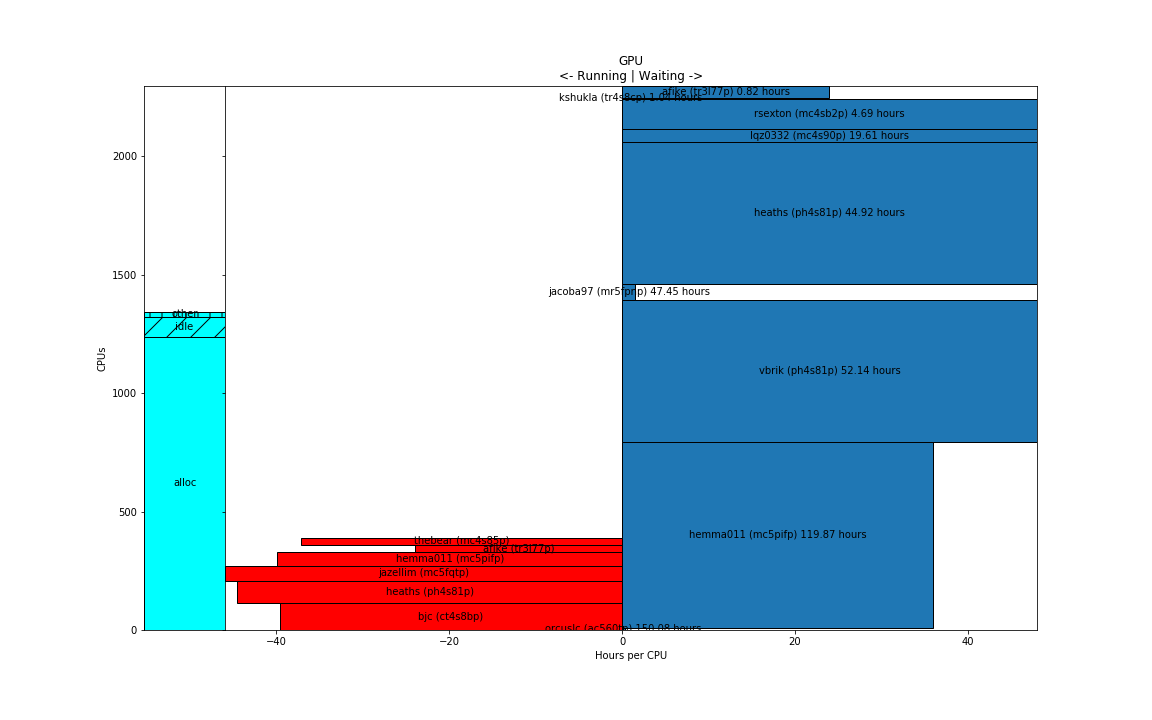

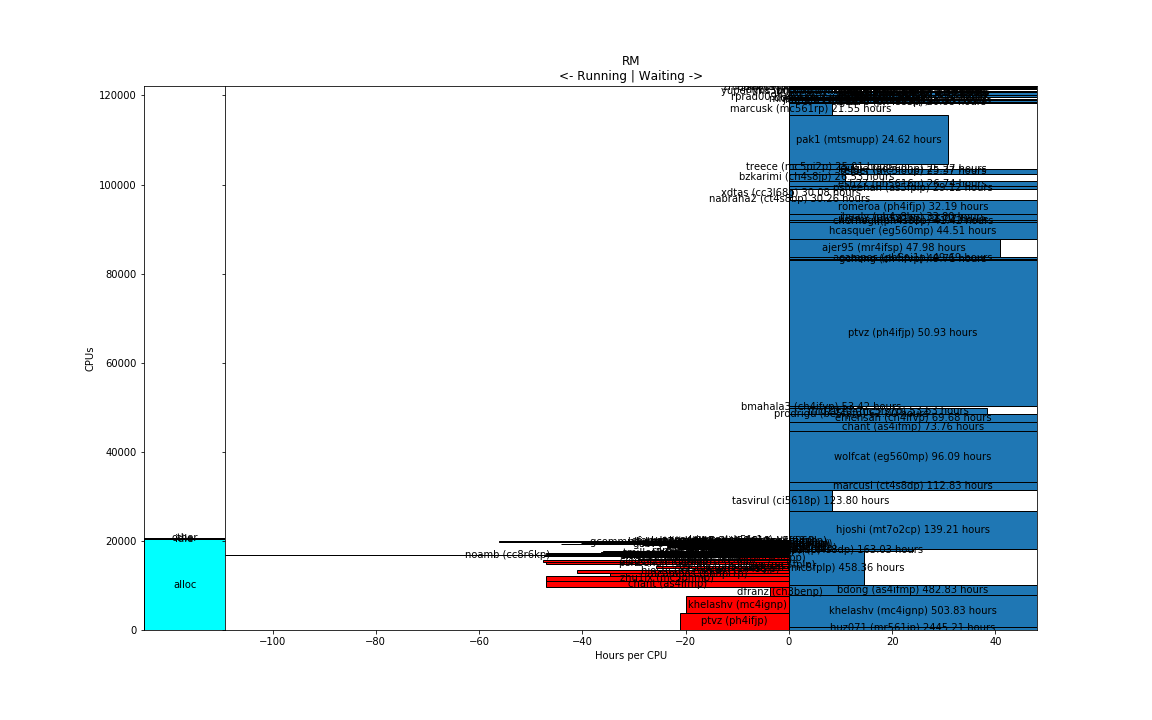

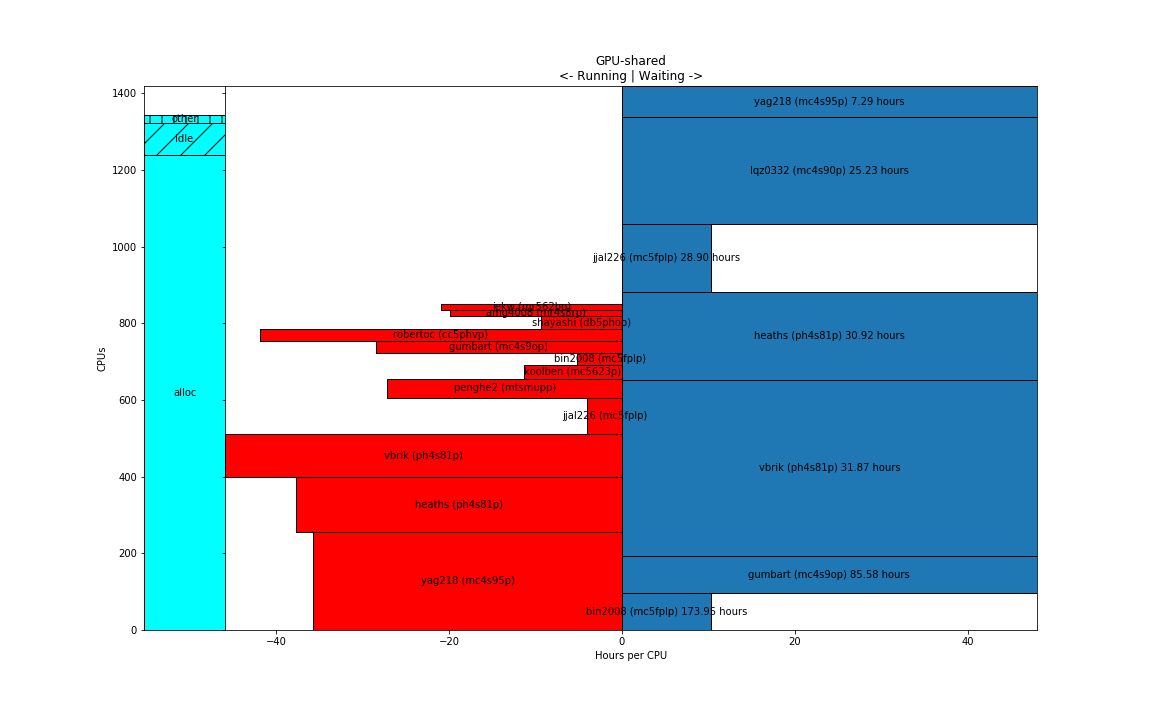

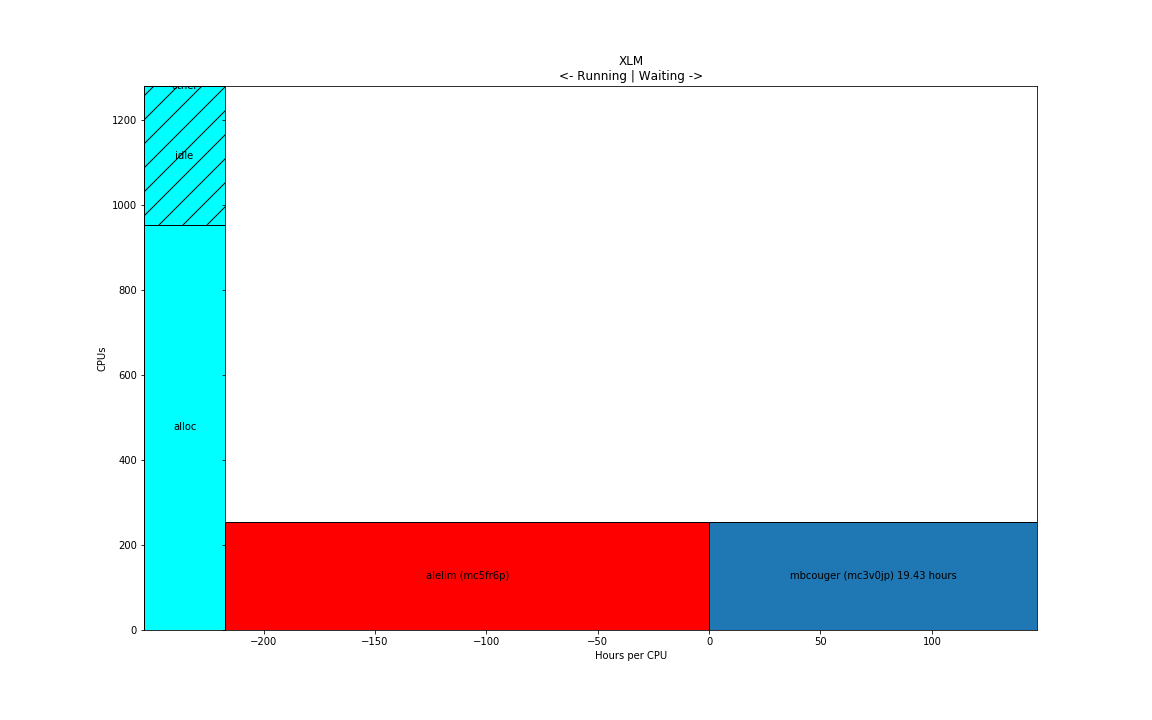

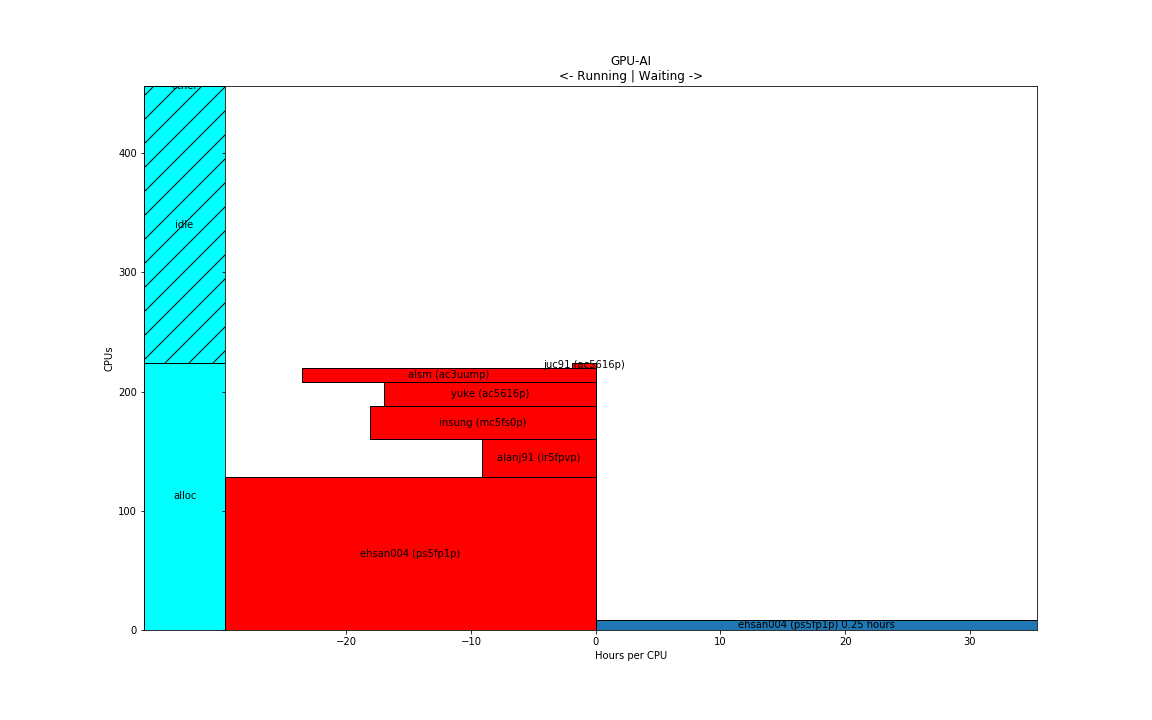

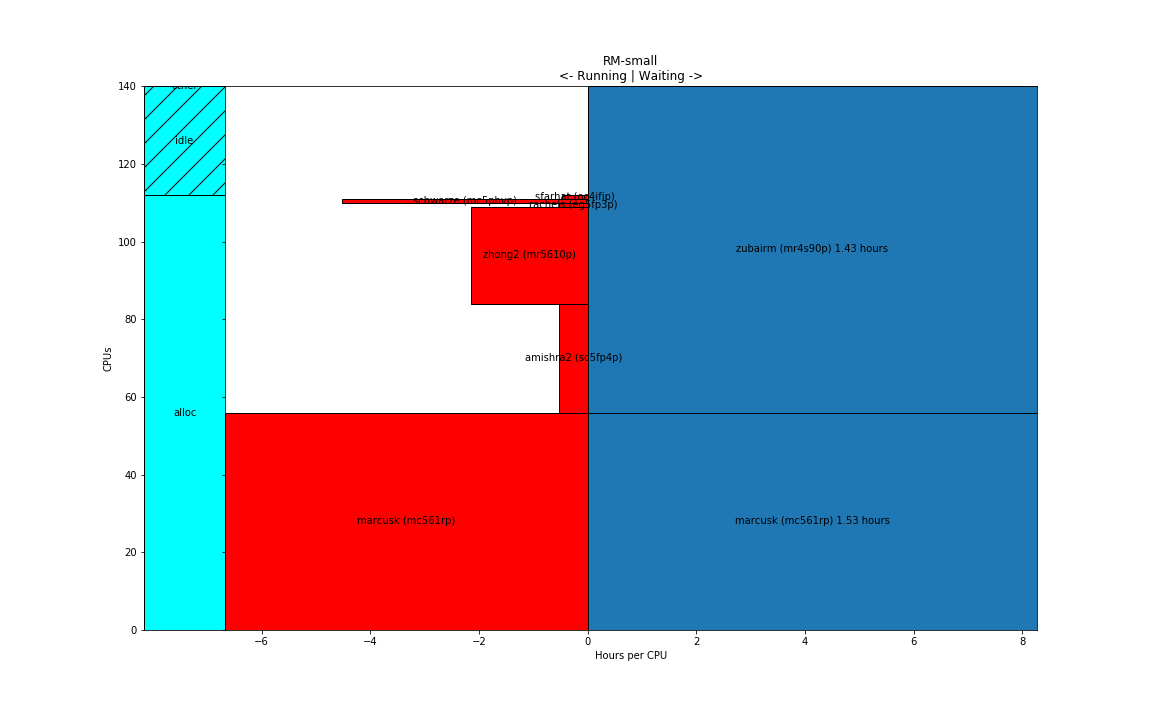

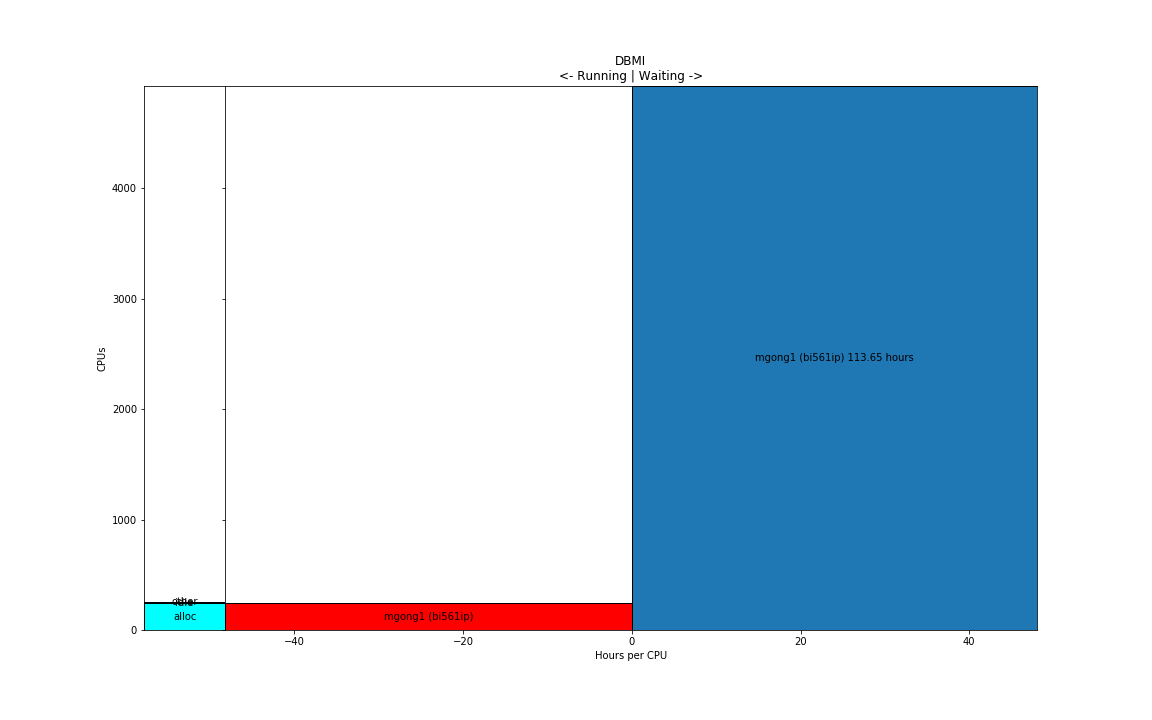

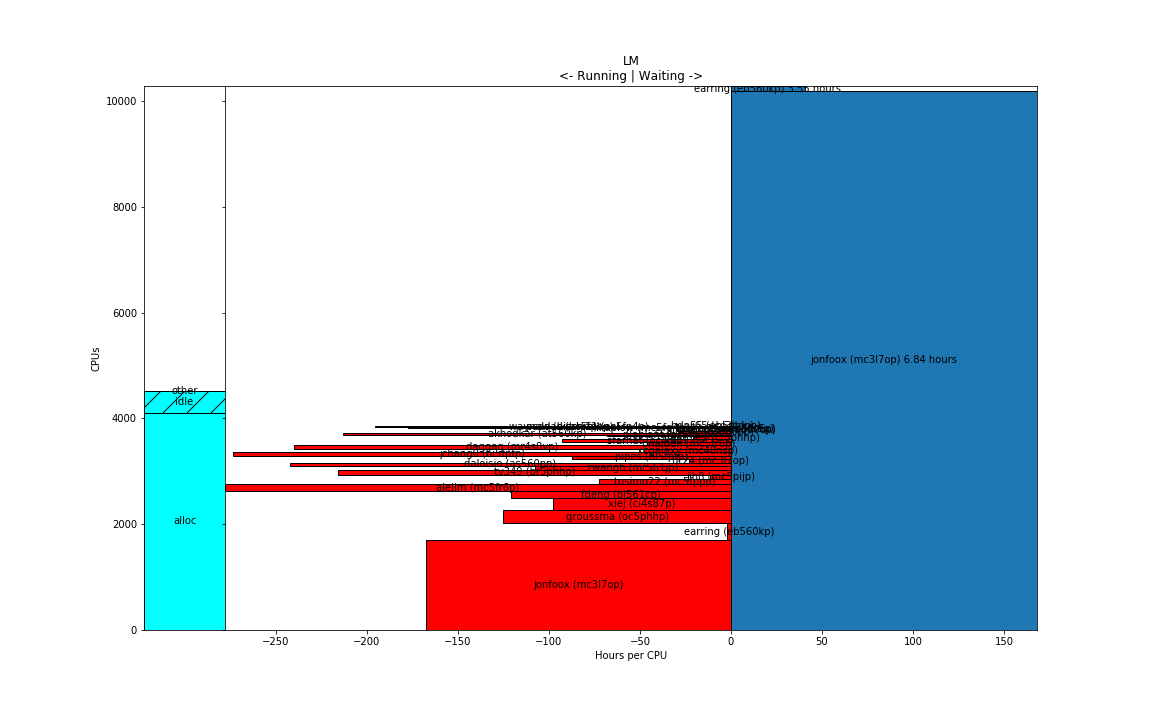

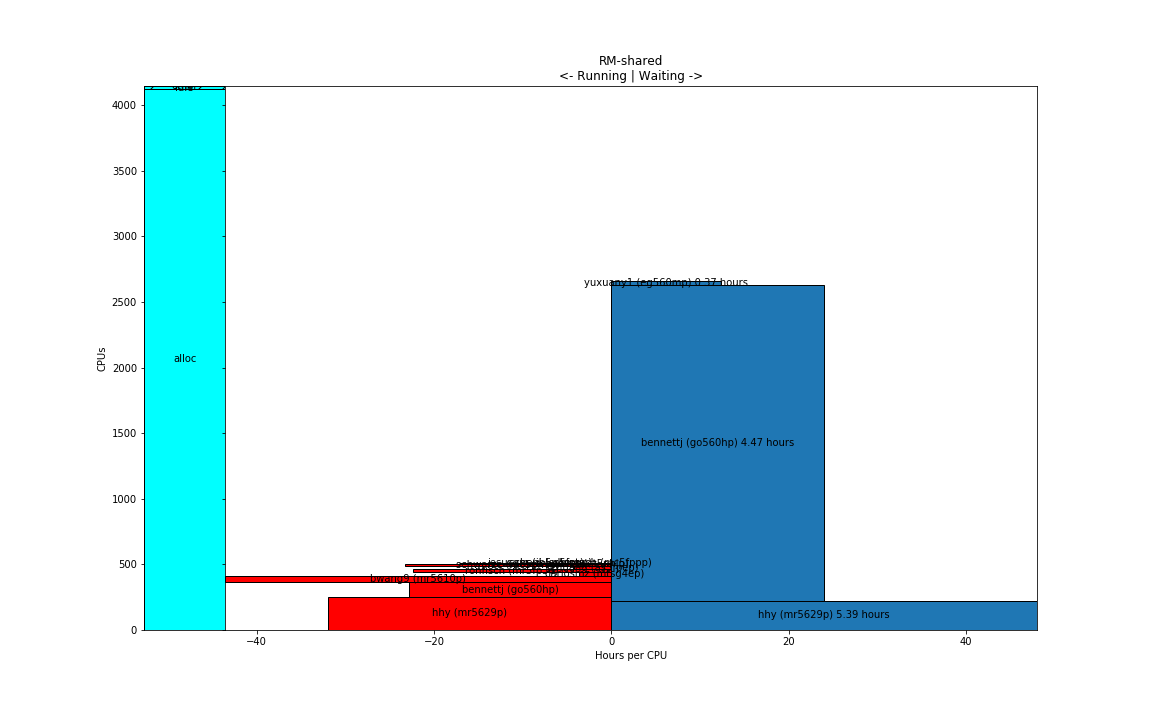

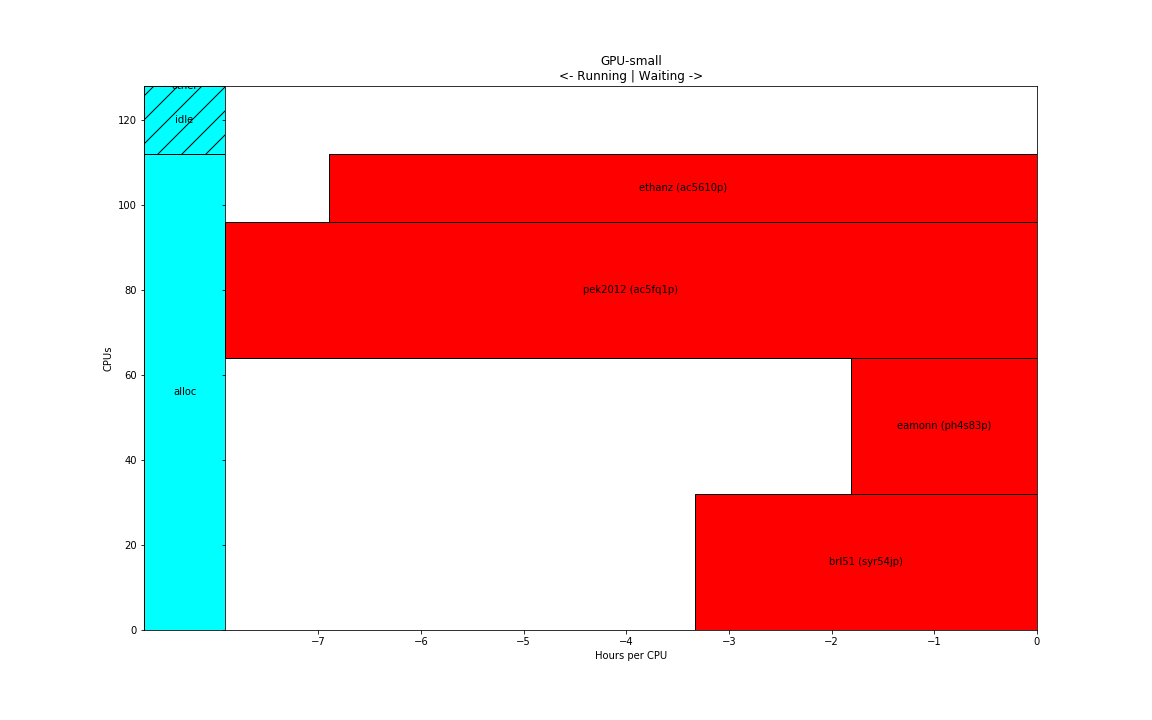

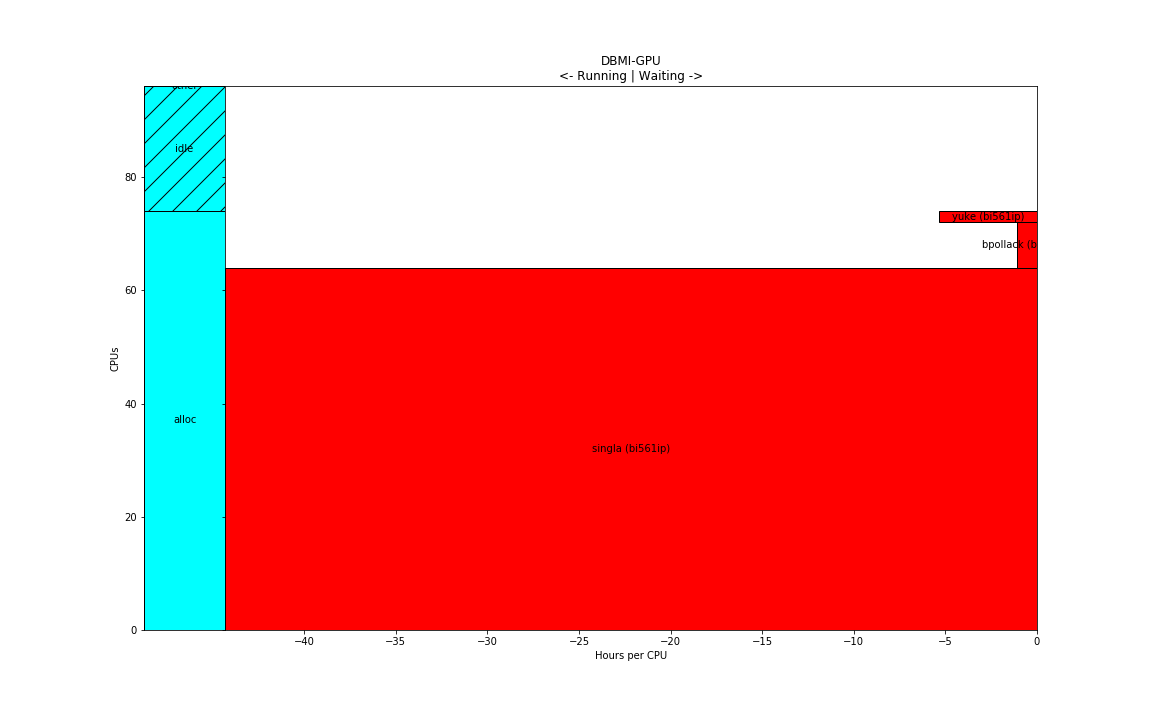

In [51]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline
#%matplotlib qt
plt.rcParams["figure.figsize"] = [16, 10]

for partition in fullDF.PARTITION.unique():
    fig = plt.figure()
    gs = GridSpec(1, 2, width_ratios=[1, 10])
    gs.update(wspace=0.0)
    axes0 = fig.add_subplot(gs[0])
    axes1 = fig.add_subplot(gs[1], sharey=axes0)
    plt.setp(axes1.get_yticklabels(), visible=False)
    axes0.set_ylabel('CPUs')
    plt.setp(axes0.get_xticklabels(), visible=False)
    axes0.get_xaxis().set_ticks([])
    ht1 = queue_plot(axes1, runDF, waitDF, partition)
    ht2 = cpu_plot(axes0, partitionCPUDF, partition)
    axes1.set_ylim(0.0, max(ht1, ht2))
    plt.show()